In [1]:
import pandas as pd
import numpy as np
from dateutil import parser
import isodate
from IPython.display import JSON

# Data visualization packages
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

# Google API
from googleapiclient.discovery import build

from config import api_key

In [3]:
channel_ids = ['UCCNgHzxVjjwU0OfqA5OiV1Q',
               'UCw5n1xUltwEYAwkqK7vXFDw',
               'UCSvdGqBMo6qY5T-KCOUUNIA',
               'UCn1BO0QdoaY0u_lKRK5AaLg',
               'UCQ-6stuMPzLTckmCBi3hnQ',
               'UCzJoaECQFRXNzRuL2tHPKFw',
               'UCVftxh4JIoqb0ociINppXrA',
              ]

In [4]:
api_service_name = "youtube"
api_version = "v3"

# Get credentials and create an API client
youtube = build(
    api_service_name, api_version, developerKey=api_key)



In [5]:
def get_channel_stats(youtube, channel_ids):
    
    all_data = []
    
    request = youtube.channels().list(
        part="snippet,contentDetails,statistics",
        id=','.join(channel_ids)
    )
    response = request.execute()

    for item in response['items']:
        data = {'channelName': item['snippet']['title'],
                'subscribers': item['statistics']['subscriberCount'],
                'views': item['statistics']['viewCount'],
                'totalVideos': item['statistics']['videoCount'],
                'playlistId': item['contentDetails']['relatedPlaylists']['uploads']
               }
        all_data.append(data)
        
    return(pd.DataFrame(all_data))

In [6]:
channel_stats = get_channel_stats(youtube, channel_ids)

In [7]:
channel_stats

,channelName,subscribers,views,totalVideos,playlistId
0,Maria's Budgeting,39100,2358311,368,UUSvdGqBMo6qY5T-KCOUUNIA
1,Beautifullymeandyou,44800,3753487,524,UUn1BO0QdoaY0u_lKRK5AaLg
2,Jordan Budgets,42700,3182192,308,UUw5n1xUltwEYAwkqK7vXFDw
3,"Oh, She Budgets!",11800,647775,212,UUCNgHzxVjjwU0OfqA5OiV1Q
4,2 Sister Bees,17100,1363174,253,UUzJoaECQFRXNzRuL2tHPKFw
5,Intentional Living,14800,2173003,490,UUVftxh4JIoqb0ociINppXrA


In [8]:
playlist_beaut = 'UUn1BO0QdoaY0u_lKRK5AaLg'
playlist_maria = 'UUSvdGqBMo6qY5T-KCOUUNIA'
playlist_ohshe = 'UUCNgHzxVjjwU0OfqA5OiV1Q'
playlist_jordan = 'UUw5n1xUltwEYAwkqK7vXFDw'

def get_video_ids(youtube, playlist_id):
    
    video_ids = []
    
    request = youtube.playlistItems().list(
        part="snippet,contentDetails",
        playlistId=playlist_id,
        maxResults = 50
    )
    response = request.execute()
    
    for item in response['items']:
        video_ids.append(item['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    
    while next_page_token is not None:
        request = youtube.playlistItems().list(
            part="snippet,contentDetails",
            playlistId=playlist_id,
            maxResults = 50,
            pageToken = next_page_token
        )
        response = request.execute()

        for item in response['items']:
            video_ids.append(item['contentDetails']['videoId'])

        next_page_token = response.get('nextPageToken')
        
    return video_ids

In [9]:
video_ids_beaut = get_video_ids(youtube, playlist_beaut)
video_ids_maria = get_video_ids(youtube, playlist_maria)
video_ids_ohshe = get_video_ids(youtube, playlist_ohshe)
video_ids_jordan = get_video_ids(youtube, playlist_jordan)

In [10]:
len(video_ids_jordan)

309

In [11]:
def get_video_details(youtube, video_ids):

    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
                          
    return pd.DataFrame(all_video_info)

In [12]:
video_df_beaut = get_video_details(youtube, video_ids_beaut)
video_df_beaut

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,92qfDB7CRWg,Beautifullymeandyou,MINI TUTORIAL SERIES EP:1 How to create A6 cas...,🌟Etsy store! Get your scratch-off challenges h...,2024-03-14T01:13:20Z,1035,233,63,PT11M12S,hd,true
1,YAd9EQTgRU0,Beautifullymeandyou,100 envelope challenge! ☺️#savingschallenges #...,100 Envelope Box! Save $5050 as little or as f...,2024-03-13T17:35:32Z,2697,232,15,PT49S,hd,false
2,NW4bqyIfD1I,Beautifullymeandyou,ETSY SHOP VLOG 06: A DAY IN THE LIFE. PACKING ...,🌟Etsy store! Get your scratch-off challenges h...,2024-03-13T00:15:01Z,2093,348,115,PT51M33S,hd,true
3,AkqXvE3Wf6g,Beautifullymeandyou,1st BUDGET OF MARCH 2024!! LARGE ETSY BUDGET A...,🌟Etsy store! Get your scratch-off challenges h...,2024-03-10T02:20:42Z,3496,592,94,PT25M36S,hd,true
4,Joyz2oBsQyo,Beautifullymeandyou,BATTLE OF THE BOXES! CASH STUFFING SAVINGS CH...,🌟Etsy store! Get your scratch-off challenges h...,2024-03-08T22:55:45Z,3521,610,90,PT28M55S,hd,true
...,...,...,...,...,...,...,...,...,...,...,...
517,NUwCO6A3TyA,Beautifullymeandyou,Plus size Macy's fashion. Inside the dressing ...,Hey Beauties and Beaus!! Plus size dresses. Pl...,2017-06-30T11:00:05Z,709,12,0,PT11M38S,hd,true
518,U660RH4ueJU,Beautifullymeandyou,UNDER 2 hr easy Crochet Senegalese Twists!! Gr...,Hi Beauties and Beaus!! I changed my hair with...,2017-06-09T19:00:03Z,174,11,2,PT4M43S,hd,false
519,NUUEw4RsgeQ,Beautifullymeandyou,My 1st Plus sized $100 Boohoo try on haul!!,Hi Beauties and Beaus!! I recently went shopp...,2017-06-05T19:45:40Z,686,27,10,PT10M15S,hd,false
520,jxzjRU5VCoI,Beautifullymeandyou,Most AFFORDABLE and REALISTIC twist out wig EV...,Hey Beauties and Beau's!! You won't believe it...,2017-05-23T00:54:14Z,7699,171,18,PT11M39S,hd,false


In [13]:
video_df_maria = get_video_details(youtube, video_ids_maria)
video_df_maria

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,y7uNAWdUjos,Maria's Budgeting,Week 3 Check In | February 2024 Budget | Incon...,Thank you so much for watching. I hope you enj...,2024-03-14T15:30:24Z,152,22,3,PT14M35S,hd,false
1,-VIF-T8XuHQ,Maria's Budgeting,February YouTube Paycheck | Cash Envelope Stuf...,Thank you so much for watching. I hope you enj...,2024-03-12T16:30:00Z,1537,176,13,PT9M12S,hd,false
2,qMW3ERe_lrg,Maria's Budgeting,Week 2 Check In | February 2024 Budget | Incon...,Thank you so much for watching. I hope you enj...,2024-03-10T22:03:03Z,899,94,6,PT16M49S,hd,false
3,fhO4893VRPU,Maria's Budgeting,February 2024 Budget | Cash Envelope and Sinki...,Thank you so much for watching. I hope you enj...,2024-03-02T16:30:06Z,3447,256,22,PT26M46S,hd,false
4,TBwJ7CFE68Y,Maria's Budgeting,Week 1 Check In | February 2024 Budget | Incon...,Thank you so much for watching. I hope you enj...,2024-03-01T16:30:10Z,792,92,4,PT12M9S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...
363,_z_TCAu1JFc,Maria's Budgeting,December 2019 Check #1 Cash Envelope Stuffing,"Hello all, I hope you all enjoyed this video. ...",2019-12-22T21:08:05Z,1499,73,4,PT26M37S,hd,false
364,QFCRFW4t2xU,Maria's Budgeting,Cash Envelope Stuffing November #2,Thank you for watching. I hope you enjoyed the...,2019-11-30T01:33:40Z,1321,75,10,PT21M5S,hd,false
365,mSfEaeIqOkA,Maria's Budgeting,November Cash Envelope Stuffing Paycheck #1 | ...,"Hello, I hope you all enjoyed the video! Thank...",2019-11-20T15:20:02Z,1964,90,3,PT13M54S,hd,false
366,kUSUNBZwF94,Maria's Budgeting,Cash Envelope Stuffing | November 2019 Check #1,Thank you all so much for watching. I hope tha...,2019-11-04T21:06:56Z,3384,144,4,PT14M27S,hd,false


In [14]:
video_df_ohshe = get_video_details(youtube, video_ids_ohshe)
video_df_ohshe

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,q711Y3vuPTw,"Oh, She Budgets!",REFLECTING ON MY 2023 GOALS: A YEAR IN REVIEW ...,REFLECTING ON MY 2023 GOALS: A YEAR IN REVIEW ...,2024-01-14T18:00:32Z,765,84,35,PT16M41S,hd,false
1,eYr5ImtDrfs,"Oh, She Budgets!",JANUARY 2024 BUDGET WITH ME | BUDGET BY PAYCHE...,MY FIRST BUDGET WITH ME IN 2024 | JANUARY 2024...,2024-01-11T18:00:19Z,1782,158,34,PT14M43S,hd,false
2,y4jrXqgCKCM,"Oh, She Budgets!",I’M BACK 💕| DECEMBER 2023 BUDGET WITH ME | BUD...,I’M BACK 💕| DECEMBER 2023 BUDGET WITH ME | BUD...,2023-12-01T20:16:43Z,1510,153,35,PT16M36S,hd,false
3,VAY4ctBgW-s,"Oh, She Budgets!",HOW TO EASE FINANCIAL ANXIETY IN 5 EASY STEPS!,HOW TO EASE FINANCIAL ANXIETY IN 5 EASY STEPS!...,2023-11-14T18:00:14Z,701,113,39,PT10M34S,hd,false
4,dT5nLbIaHaE,"Oh, She Budgets!",NOVEMBER 2023 BUDGET WITH ME | BUDGET BY PAYCH...,NOVEMBER 2023 BUDGET WITH ME | BUDGET BY PAYCH...,2023-11-03T17:00:29Z,1460,134,64,PT12M25S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...
207,e43irJXURRk,"Oh, She Budgets!",EXTREME CLEAN WITH ME: CLEANING MY DAUGHTER'S ...,HELLO! WELCOME BACK TO MY CHANNEL!\n\nI finall...,2019-05-03T01:01:43Z,1979,72,75,PT13M18S,hd,false
208,M95Xs5jWUUo,"Oh, She Budgets!",HOW TO MANAGE AND SAVE YOUR MONEY IN 2019 || P...,HELLO! WELCOME TO MY CHANNEL! \n\nIn this vide...,2019-02-12T02:33:06Z,273,24,26,PT5M52S,hd,false
209,Ocbkj_T3J_U,"Oh, She Budgets!",HOW TO BOOST YOUR CREDIT SCORE || MY 30 DAY CR...,HELLO! WELCOME TO MY CHANNEL! \n\nHope you guy...,2019-02-05T23:28:06Z,230,22,14,PT7M7S,hd,false
210,2atv4u2v69A,"Oh, She Budgets!",HOW TO: MAKE MONEY ON YOUR IPHONE || BEST MONE...,WELCOME TO MY CHANNEL! \n\nIn this video I'm g...,2019-01-31T04:01:47Z,2530,48,6,PT6M22S,hd,false


In [15]:
video_df_jordan = get_video_details(youtube, video_ids_jordan)
video_df_jordan

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,mK_EpPXYpJ0,Jordan Budgets,UNSTUFFING CASH BINDER | UHAUL | GOODBYE MONEY...,Cash stuffing timmeee!!! \n\nThe new monthly c...,2024-03-11T22:29:31Z,4319,439,60,PT16M55S,hd,false
1,_j2-n6p2Q3A,Jordan Budgets,CASH STUFFING YOUTUBE CHECK | HOW MUCH YOUTUBE...,Cash stuffing timmeee!!! \n\nThe new monthly c...,2024-02-29T21:17:45Z,3519,513,73,PT27M2S,hd,false
2,c76bugITyeY,Jordan Budgets,LOW INCOME CASH STUFFING | SINGLE MOM CASH STU...,Cash stuffing timmeee!!! \n\nThe new monthly c...,2024-02-21T20:58:00Z,3737,447,65,PT20M39S,hd,false
3,Rn7bE529jHg,Jordan Budgets,Is it too late?,Am I too late to share my 2024 goals? lol..\n\...,2024-02-17T22:43:58Z,4283,456,44,PT18M30S,hd,false
4,1w-_B4ek4N0,Jordan Budgets,Cash Stuffing on Valentines Day! | Happy Febru...,Cash stuffing timmeee!!! \n\nhttps://www.jorda...,2024-02-14T20:36:33Z,3215,438,95,PT18M12S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...
304,8TqzBkFC_Xc,Jordan Budgets,WEEKLY CHECK IN | SAVINGS CHALLENGES | WHAT I ...,Hi budgeting family! Today I'm sharing all of ...,2021-07-26T16:00:09Z,1748,150,15,PT9M29S,hd,false
305,4b4v42NHqcE,Jordan Budgets,WEEK OF GROCERIES | GROCERY HAUL | LOW INCOME...,Hi budgeting family! In this video I rant abou...,2021-07-23T14:29:01Z,1874,135,9,PT5M56S,hd,false
306,MKGi_7dyGCc,Jordan Budgets,July 2021 | $600 CASH ENVELOPE STUFFING | LOW ...,Hi budgeting family! Today we are cash stuffin...,2021-07-20T17:15:01Z,5686,321,40,PT12M56S,hd,false
307,sDILblur-6E,Jordan Budgets,July Week 3 Budget | Low Income | Budget With Me,Hi budgeting family! Thank you to those of you...,2021-07-18T16:21:50Z,2785,189,6,PT5M30S,hd,false


## Data Pre-Processing

In [16]:
video_df_beaut.isnull().any()

video_id        False
channelTitle    False
title           False
description     False
publishedAt     False
viewCount       False
likeCount       False
commentCount    False
duration        False
definition      False
caption         False
dtype: bool

In [17]:
video_df_maria.isnull().any()

video_id        False
channelTitle    False
title           False
description     False
publishedAt     False
viewCount       False
likeCount       False
commentCount     True
duration        False
definition      False
caption         False
dtype: bool

In [18]:
video_df_ohshe.isnull().any()

video_id        False
channelTitle    False
title           False
description     False
publishedAt     False
viewCount       False
likeCount       False
commentCount     True
duration        False
definition      False
caption         False
dtype: bool

In [19]:
video_df_jordan.isnull().any()

video_id        False
channelTitle    False
title           False
description     False
publishedAt     False
viewCount       False
likeCount       False
commentCount    False
duration        False
definition      False
caption         False
dtype: bool

In [20]:
video_df_beaut.dtypes

video_id        object
channelTitle    object
title           object
description     object
publishedAt     object
viewCount       object
likeCount       object
commentCount    object
duration        object
definition      object
caption         object
dtype: object

In [21]:
video_df_maria.dtypes

video_id        object
channelTitle    object
title           object
description     object
publishedAt     object
viewCount       object
likeCount       object
commentCount    object
duration        object
definition      object
caption         object
dtype: object

In [22]:
video_df_ohshe.dtypes

video_id        object
channelTitle    object
title           object
description     object
publishedAt     object
viewCount       object
likeCount       object
commentCount    object
duration        object
definition      object
caption         object
dtype: object

In [23]:
video_df_jordan.dtypes

video_id        object
channelTitle    object
title           object
description     object
publishedAt     object
viewCount       object
likeCount       object
commentCount    object
duration        object
definition      object
caption         object
dtype: object

In [24]:
numeric_cols = ['viewCount', 'likeCount', 'commentCount']
video_df_beaut[numeric_cols] = video_df_beaut[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)
video_df_maria[numeric_cols] = video_df_maria[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)
video_df_ohshe[numeric_cols] = video_df_ohshe[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)
video_df_jordan[numeric_cols] = video_df_jordan[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis = 1)

In [25]:
video_df_beaut['publishedAt'] = video_df_beaut['publishedAt'].apply(lambda x: parser.parse(x))
video_df_maria['publishedAt'] = video_df_maria['publishedAt'].apply(lambda x: parser.parse(x))
video_df_ohshe['publishedAt'] = video_df_ohshe['publishedAt'].apply(lambda x: parser.parse(x))
video_df_jordan['publishedAt'] = video_df_jordan['publishedAt'].apply(lambda x: parser.parse(x))

video_df_beaut['publishDayName'] = video_df_beaut['publishedAt'].apply(lambda x: x.strftime("%A"))
video_df_maria['publishDayName'] = video_df_maria['publishedAt'].apply(lambda x: x.strftime("%A"))
video_df_ohshe['publishDayName'] = video_df_ohshe['publishedAt'].apply(lambda x: x.strftime("%A"))
video_df_jordan['publishDayName'] = video_df_jordan['publishedAt'].apply(lambda x: x.strftime("%A"))

In [26]:
video_df_beaut['durationSecs'] = video_df_beaut['duration'].apply(lambda x: isodate.parse_duration(x))
video_df_maria['durationSecs'] = video_df_maria['duration'].apply(lambda x: isodate.parse_duration(x))
video_df_ohshe['durationSecs'] = video_df_ohshe['duration'].apply(lambda x: isodate.parse_duration(x))
video_df_jordan['durationSecs'] = video_df_jordan['duration'].apply(lambda x: isodate.parse_duration(x))

video_df_beaut['durationSecs'] = video_df_beaut['durationSecs'].astype('timedelta64[s]')
video_df_maria['durationSecs'] = video_df_maria['durationSecs'].astype('timedelta64[s]')
video_df_ohshe['durationSecs'] = video_df_ohshe['durationSecs'].astype('timedelta64[s]')
video_df_jordan['durationSecs'] = video_df_jordan['durationSecs'].astype('timedelta64[s]')

In [27]:
video_df_beaut[['durationSecs', 'duration']]

,durationSecs,duration
0,672.0,PT11M12S
1,49.0,PT49S
2,3093.0,PT51M33S
3,1536.0,PT25M36S
4,1735.0,PT28M55S
...,...,...
517,698.0,PT11M38S
518,283.0,PT4M43S
519,615.0,PT10M15S
520,699.0,PT11M39S


In [28]:
video_df_maria[['durationSecs', 'duration']]

,durationSecs,duration
0,875.0,PT14M35S
1,552.0,PT9M12S
2,1009.0,PT16M49S
3,1606.0,PT26M46S
4,729.0,PT12M9S
...,...,...
363,1597.0,PT26M37S
364,1265.0,PT21M5S
365,834.0,PT13M54S
366,867.0,PT14M27S


In [29]:
video_df_ohshe[['durationSecs', 'duration']]

,durationSecs,duration
0,1001.0,PT16M41S
1,883.0,PT14M43S
2,996.0,PT16M36S
3,634.0,PT10M34S
4,745.0,PT12M25S
...,...,...
207,798.0,PT13M18S
208,352.0,PT5M52S
209,427.0,PT7M7S
210,382.0,PT6M22S


In [30]:
video_df_jordan[['durationSecs', 'duration']]

,durationSecs,duration
0,1015.0,PT16M55S
1,1622.0,PT27M2S
2,1239.0,PT20M39S
3,1110.0,PT18M30S
4,1092.0,PT18M12S
...,...,...
304,569.0,PT9M29S
305,356.0,PT5M56S
306,776.0,PT12M56S
307,330.0,PT5M30S


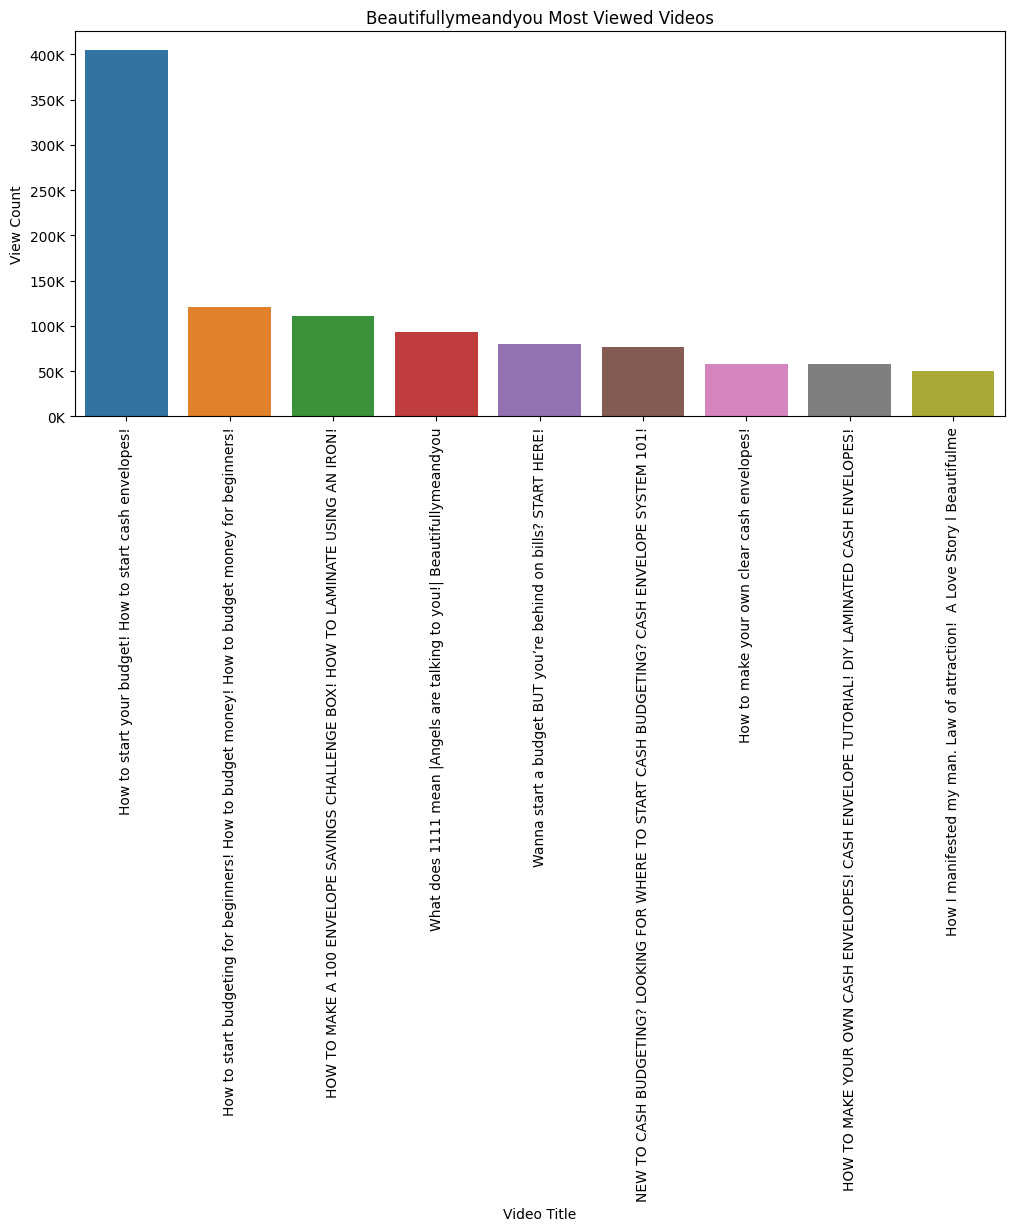

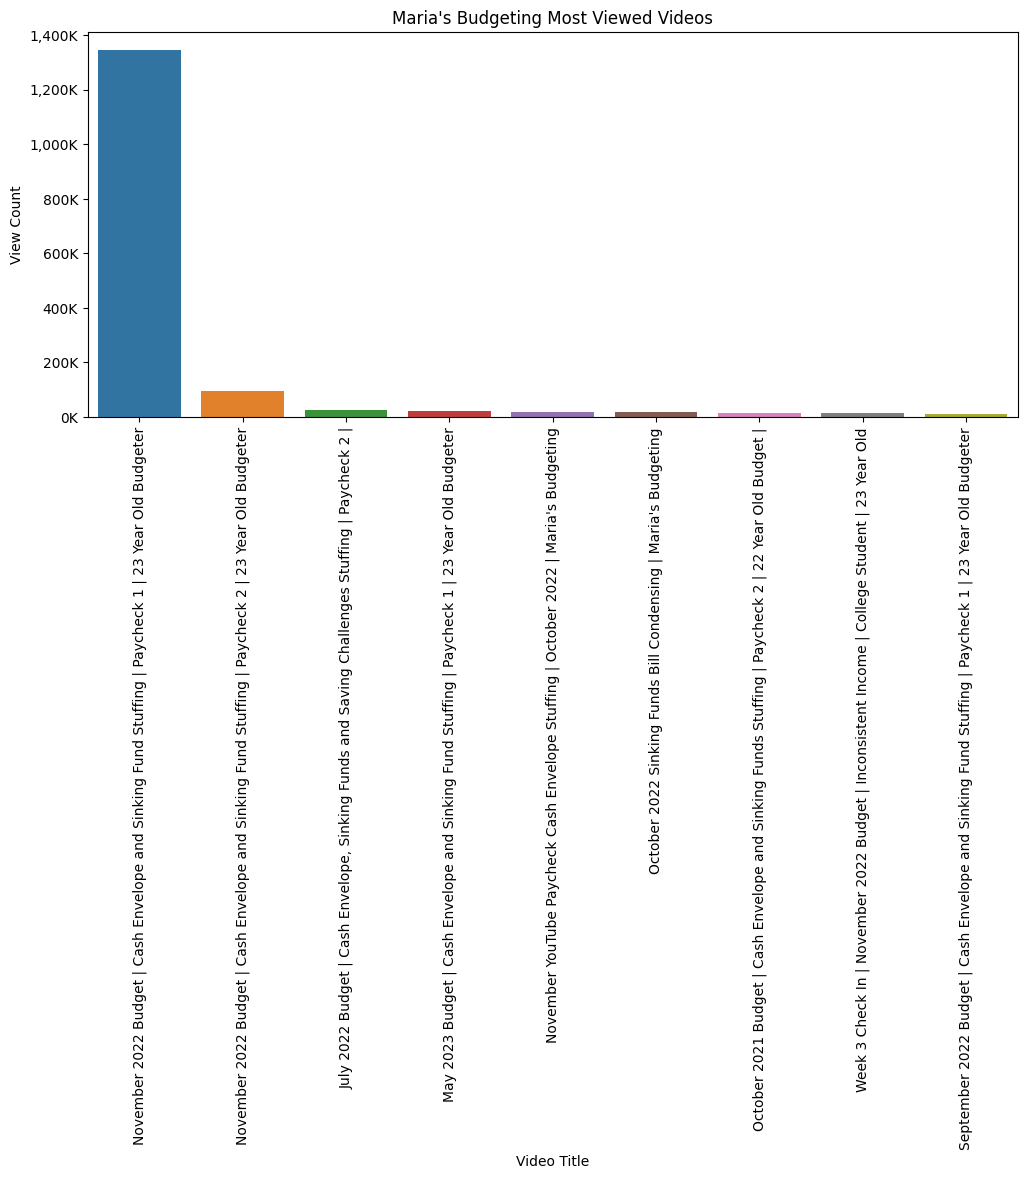

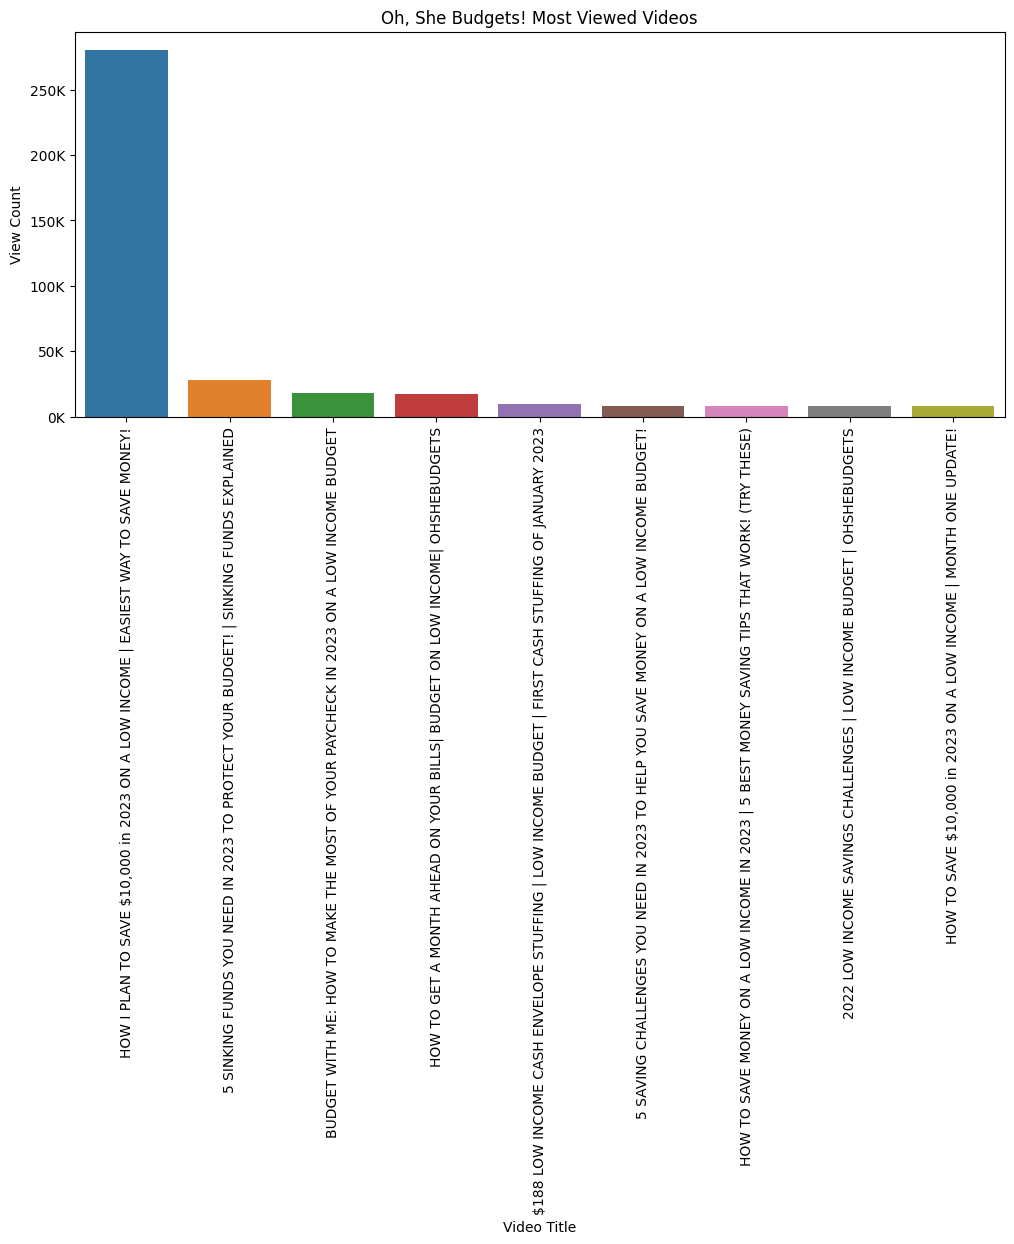

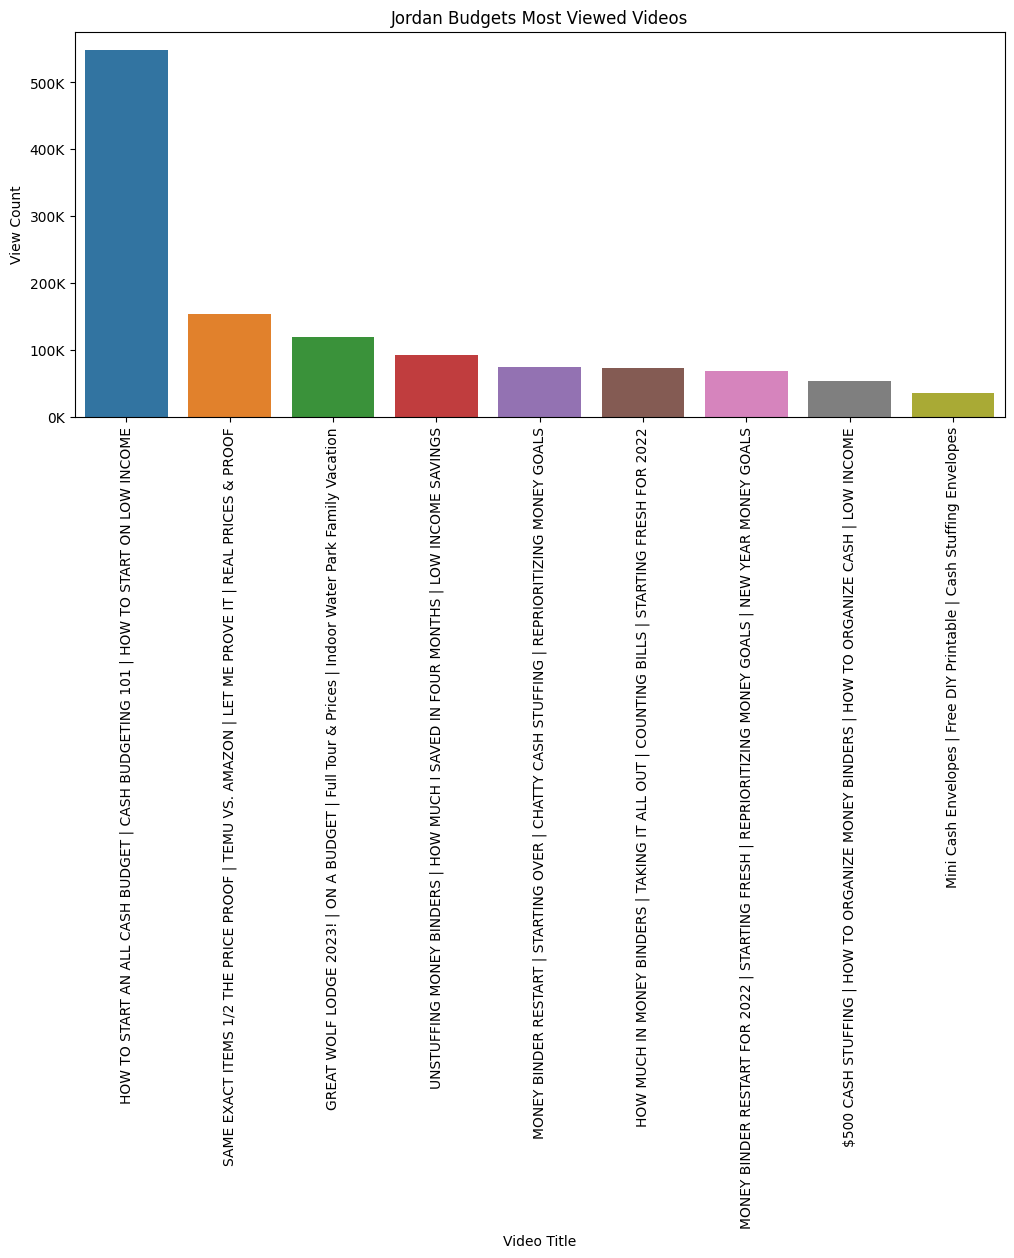

In [31]:
video_data = [video_df_beaut, video_df_maria, video_df_ohshe, video_df_jordan]

for i in video_data:
    x = 'title'
    y = 'viewCount'
    plt.figure(figsize=(12,5))
    sns.barplot(x=x, y=y, data = i.sort_values('viewCount', ascending=False)[0:9]).yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))
    plt.xticks(rotation=90)
    plt.xlabel('Video Title')
    plt.ylabel('View Count')
    plt.title(i['channelTitle'][0] + ' Most Viewed Videos')

/opt/homebrew/opt/ipython/libexec/lib/python3.11/site-packages/IPython/core/events.py:93: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  func(*args, **kwargs)


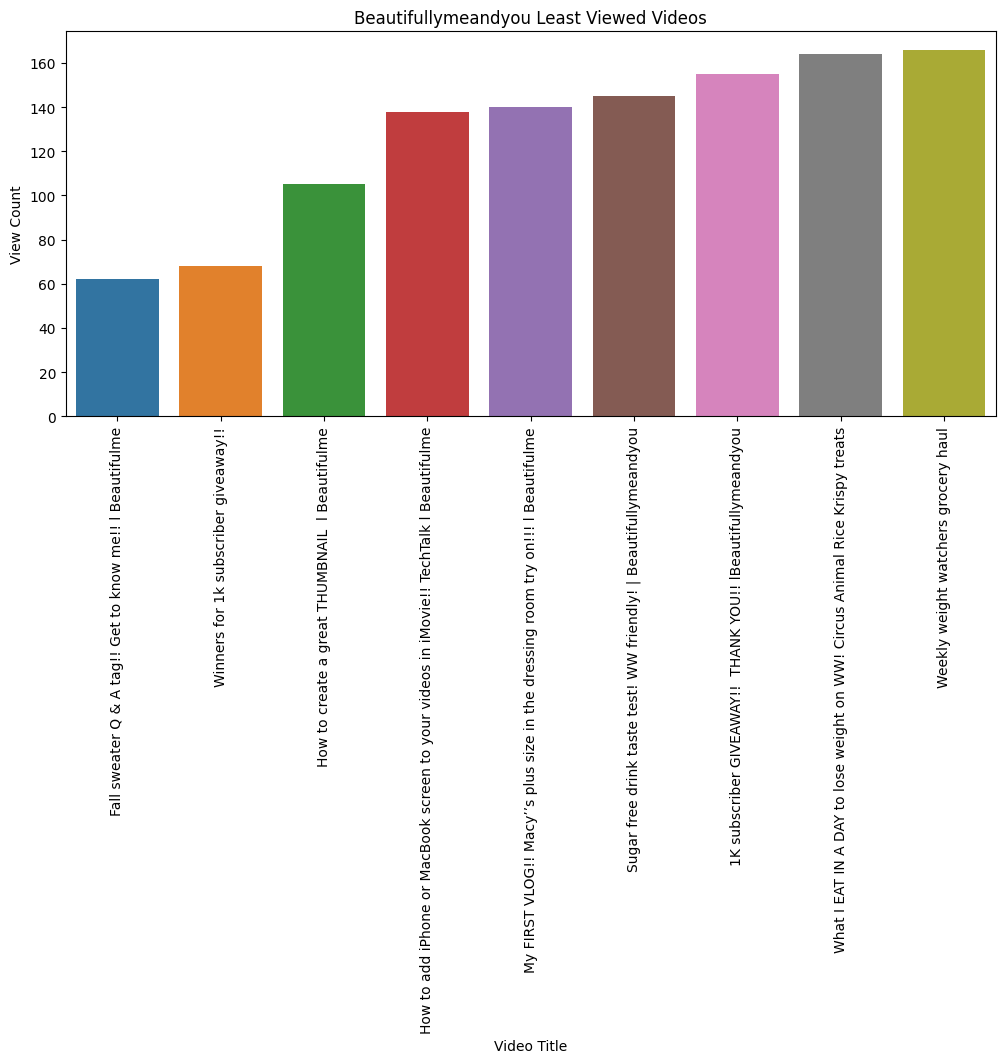

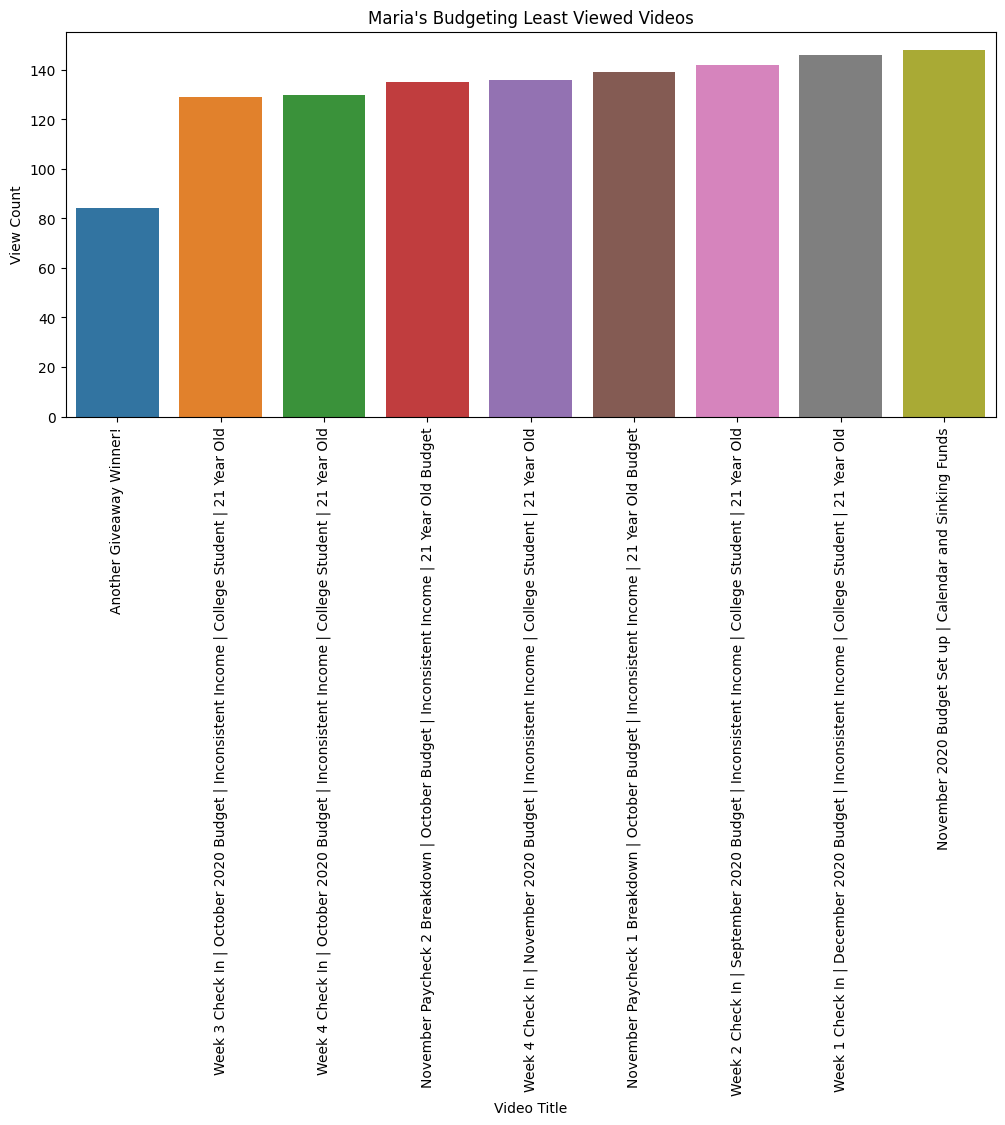

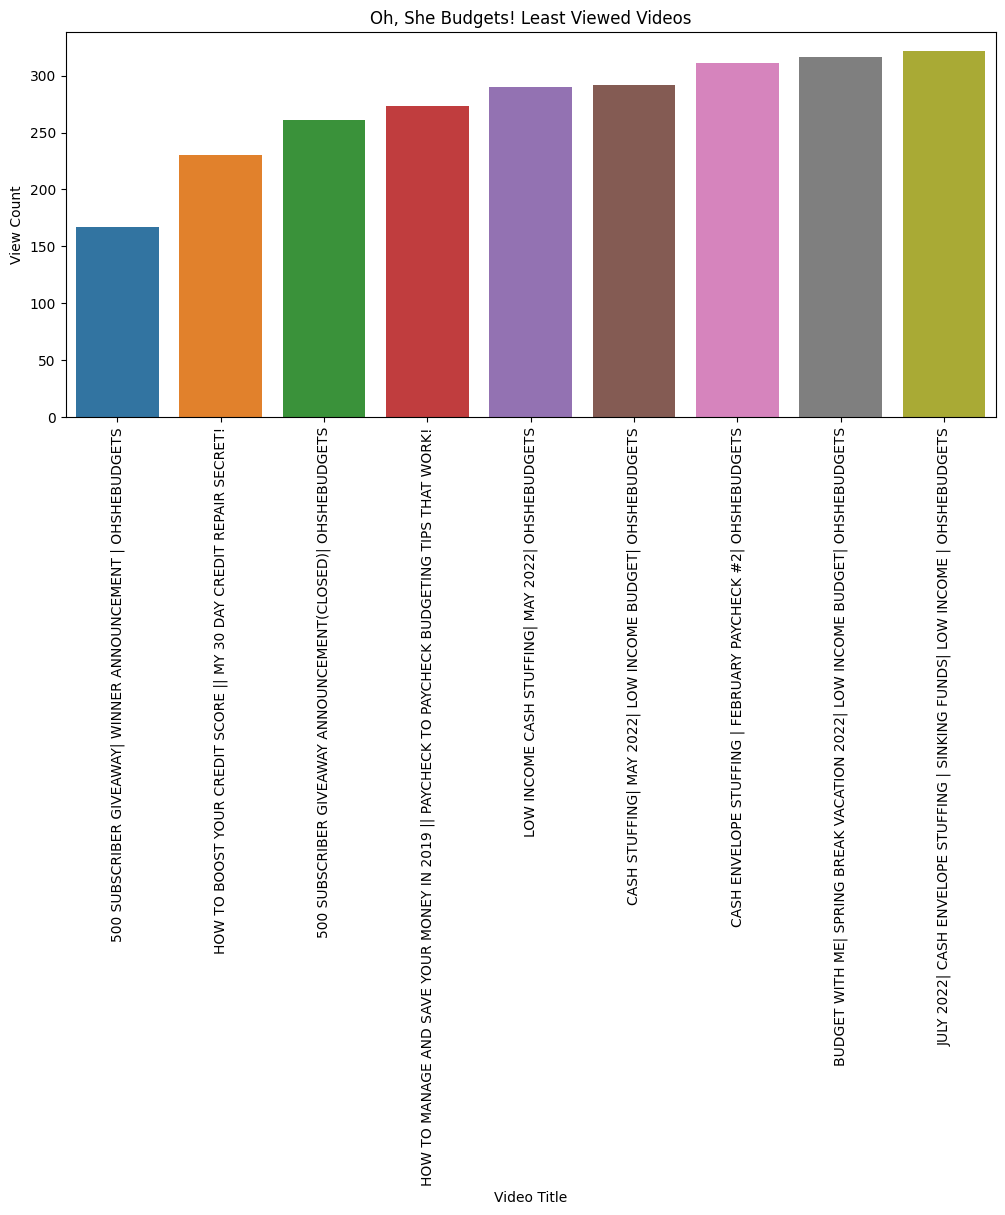

/opt/homebrew/opt/ipython/libexec/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


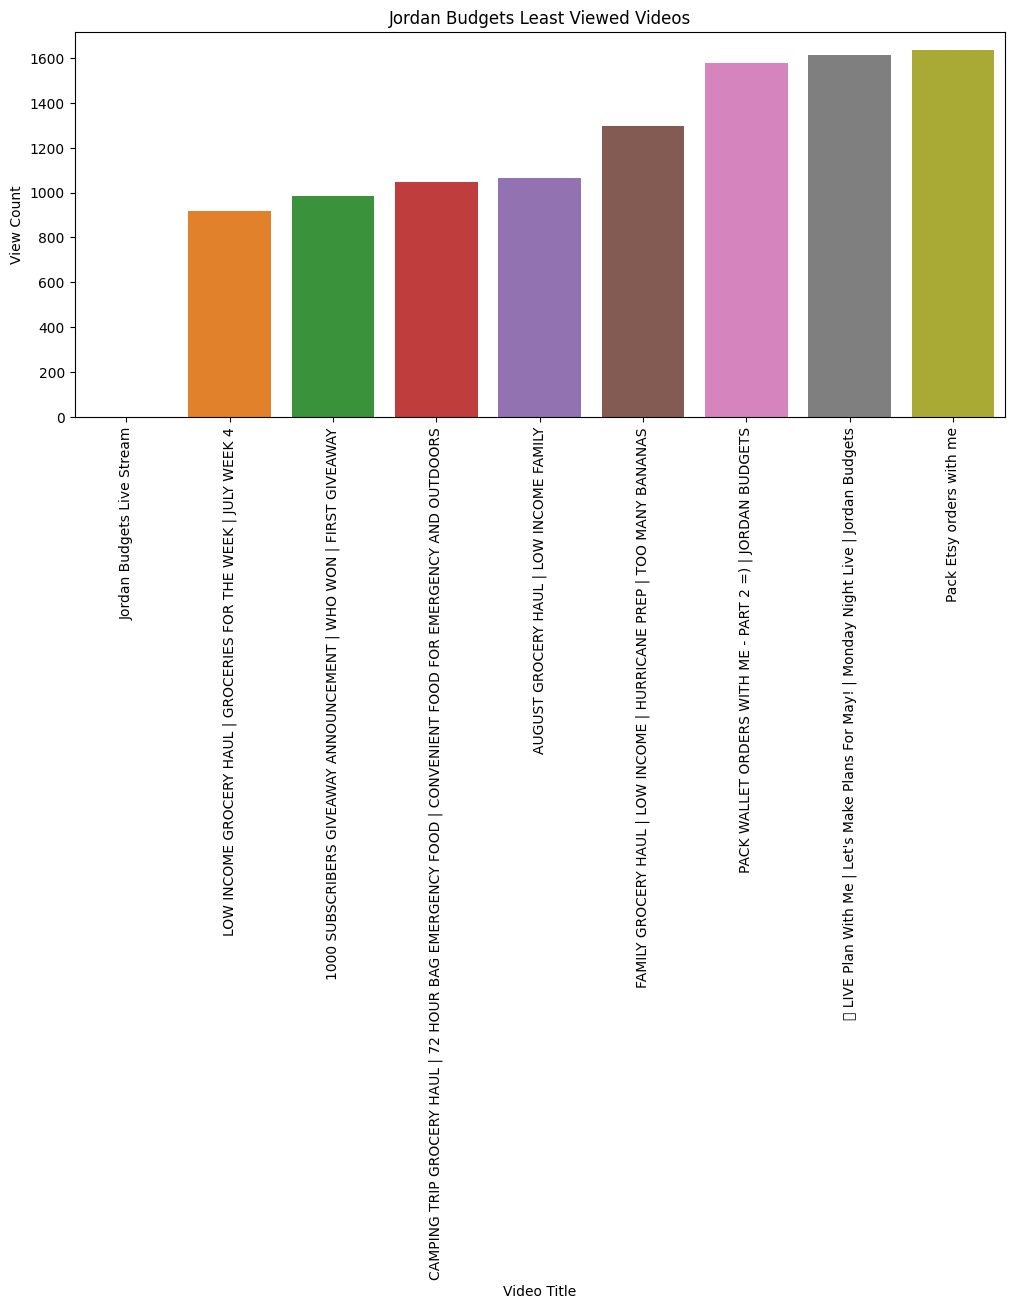

In [32]:
for i in video_data:
    x = 'title'
    y = 'viewCount'
    plt.figure(figsize=(12,5))
    sns.barplot(x=x, y=y, data = i.sort_values('viewCount', ascending=True)[0:9])
    plt.xticks(rotation=90)
    plt.xlabel('Video Title')
    plt.ylabel('View Count')
    plt.title(i['channelTitle'][0] + ' Least Viewed Videos')

In [33]:
# new_video_data = pd.concat(video_data)
new_video_data = [video_data[0], video_data[1], video_data[2], video_data[3]]
concat_video_data = pd.concat(new_video_data, ignore_index=True)
concat_video_data

,video_id,channelTitle,title,description,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,publishDayName,durationSecs
0,92qfDB7CRWg,Beautifullymeandyou,MINI TUTORIAL SERIES EP:1 How to create A6 cas...,🌟Etsy store! Get your scratch-off challenges h...,2024-03-14 01:13:20+00:00,1035.0,233.0,63.0,PT11M12S,hd,true,Thursday,672.0
1,YAd9EQTgRU0,Beautifullymeandyou,100 envelope challenge! ☺️#savingschallenges #...,100 Envelope Box! Save $5050 as little or as f...,2024-03-13 17:35:32+00:00,2697.0,232.0,15.0,PT49S,hd,false,Wednesday,49.0
2,NW4bqyIfD1I,Beautifullymeandyou,ETSY SHOP VLOG 06: A DAY IN THE LIFE. PACKING ...,🌟Etsy store! Get your scratch-off challenges h...,2024-03-13 00:15:01+00:00,2093.0,348.0,115.0,PT51M33S,hd,true,Wednesday,3093.0
3,AkqXvE3Wf6g,Beautifullymeandyou,1st BUDGET OF MARCH 2024!! LARGE ETSY BUDGET A...,🌟Etsy store! Get your scratch-off challenges h...,2024-03-10 02:20:42+00:00,3496.0,592.0,94.0,PT25M36S,hd,true,Sunday,1536.0
4,Joyz2oBsQyo,Beautifullymeandyou,BATTLE OF THE BOXES! CASH STUFFING SAVINGS CH...,🌟Etsy store! Get your scratch-off challenges h...,2024-03-08 22:55:45+00:00,3521.0,610.0,90.0,PT28M55S,hd,true,Friday,1735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1406,8TqzBkFC_Xc,Jordan Budgets,WEEKLY CHECK IN | SAVINGS CHALLENGES | WHAT I ...,Hi budgeting family! Today I'm sharing all of ...,2021-07-26 16:00:09+00:00,1748.0,150.0,15.0,PT9M29S,hd,false,Monday,569.0
1407,4b4v42NHqcE,Jordan Budgets,WEEK OF GROCERIES | GROCERY HAUL | LOW INCOME...,Hi budgeting family! In this video I rant abou...,2021-07-23 14:29:01+00:00,1874.0,135.0,9.0,PT5M56S,hd,false,Friday,356.0
1408,MKGi_7dyGCc,Jordan Budgets,July 2021 | $600 CASH ENVELOPE STUFFING | LOW ...,Hi budgeting family! Today we are cash stuffin...,2021-07-20 17:15:01+00:00,5686.0,321.0,40.0,PT12M56S,hd,false,Tuesday,776.0
1409,sDILblur-6E,Jordan Budgets,July Week 3 Budget | Low Income | Budget With Me,Hi budgeting family! Thank you to those of you...,2021-07-18 16:21:50+00:00,2785.0,189.0,6.0,PT5M30S,hd,false,Sunday,330.0


Text(0, 0.5, 'View Count')

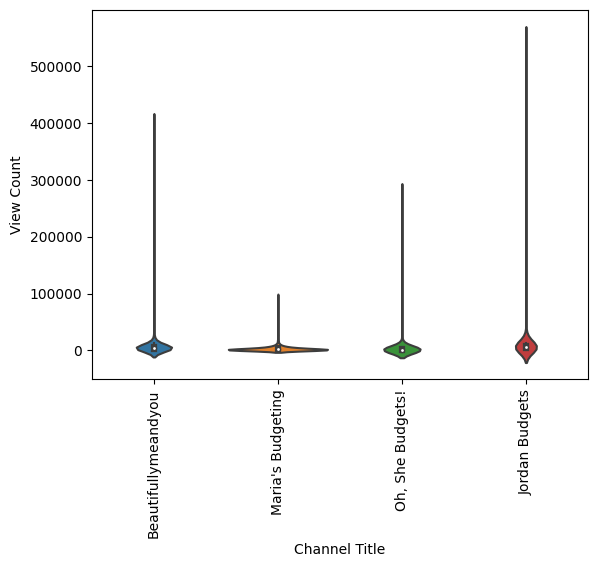

In [34]:
ax = sns.violinplot(x='channelTitle', y=concat_video_data[concat_video_data['viewCount']<800000]['viewCount'], data=concat_video_data) #.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}'.format(x/1000) + 'K'))
plt.xticks(rotation=90)
plt.xlabel('Channel Title')
plt.ylabel('View Count')

Text(55.29570833333334, 0.5, 'View Count')

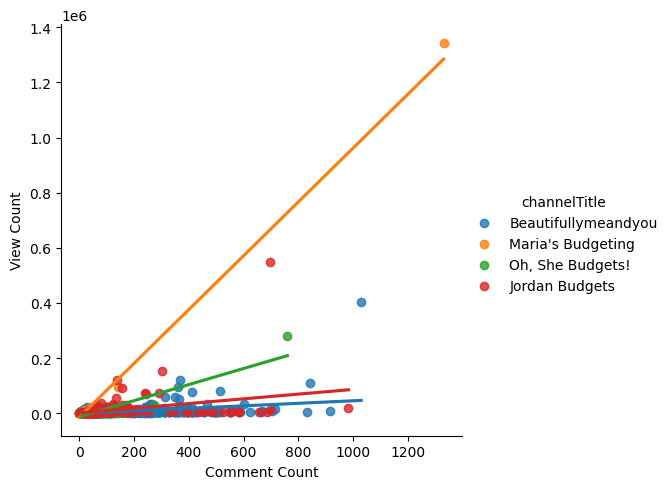

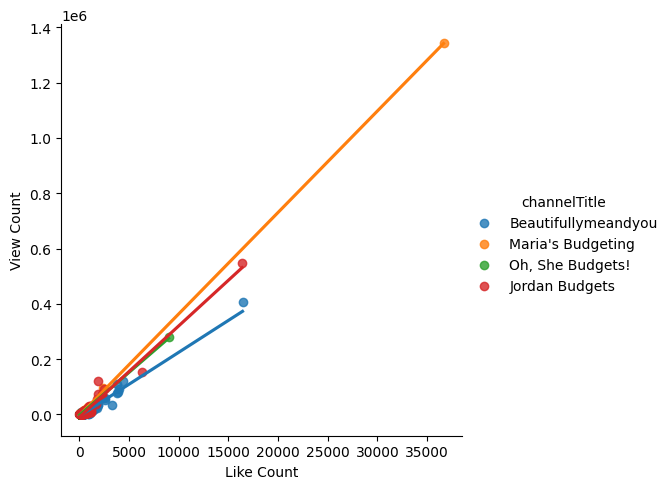

In [40]:
#fig, ax = plt.subplots(1, 2)
sns.lmplot(data = concat_video_data, x = 'commentCount', y ='viewCount', hue = 'channelTitle', ci=None)#.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.ylabel('View Count')
plt.xlabel('Comment Count')
sns.lmplot(data = concat_video_data, x = 'likeCount', y = 'viewCount', hue = 'channelTitle', ci=None)#.legend(loc='center left', bbox_to_anchor=(1.25, 0.5), ncol=1)
plt.xlabel('Like Count')
plt.ylabel('View Count')

/var/folders/18/bwc4b6qn1qb9mvgwlq4r5lnm0000gn/T/ipykernel_4060/3778946399.py:1: FutureWarning: This dataframe has a column name that matches the 'value_name' column name of the resulting Dataframe. In the future this will raise an error, please set the 'value_name' parameter of DataFrame.melt to a unique name.
  sns.boxplot(data=concat_video_data.melt(id_vars=['channelTitle'], value_vars=['likeCount', 'commentCount'], var_name='Section', value_name='viewCount')


Text(0, 0.5, 'View Count')

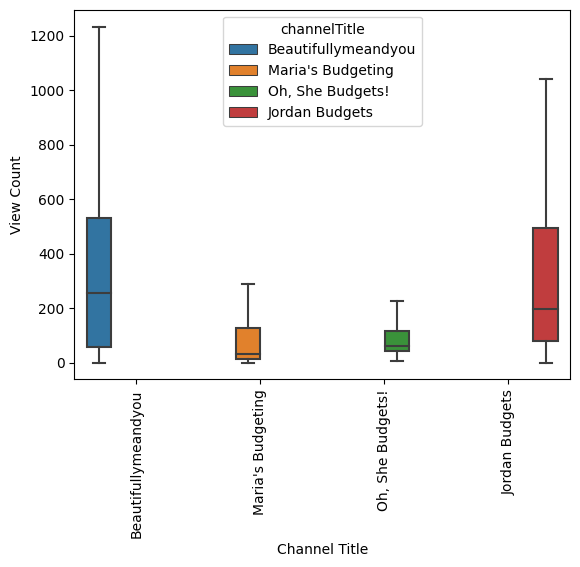

In [36]:
sns.boxplot(data=concat_video_data.melt(id_vars=['channelTitle'], value_vars=['likeCount', 'commentCount'], var_name='Section', value_name='viewCount')
            , x='channelTitle', y='viewCount', hue='channelTitle', showfliers=False)
plt.xticks(rotation=90)
plt.xlabel('Channel Title')
plt.ylabel('View Count')